# Questão 3.

Considere uma rede deep learning convolutiva (treinada) - CNN aplicada à classificação de padrões em imagens. A base de dados considerada é a CIFAR-10 (pesquise). A referida base de dados consiste de 60 mil imagens coloridas de 32x32 pixels, com 50 mil para treino e 10 mil para teste. As imagens estão divididas em 10 classes, a saber: avião, navio, caminhão, automóvel, sapo, pássaro, cachorro, gato, cavalo e cervo. Cada imagem possui apenas um dos objetos da classe de interesse, podendo estar parcialmente obstruído por outros objetos que não pertençam a esse conjunto. Apresente os resultados da classificação em uma matriz de confusão.

Obs. Pesquise e utilize uma rede convolutiva já treinada

## Imports das bibliotecas

In [ ]:
#!pip install tensorflow --upgrade
#!pip install keras --upgrade

## Imports das bibliotecas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.applications import ResNet50
from tensorflow.keras import models
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import itertools

## Carregar o dataset _CIFAR-10_

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalização dos valores das imagens (0 <=val<= 1)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Converção de rótulos para o one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

## Definição do modelo

In [4]:
classes = ['avião', 'automóvel', 'pássaro', 'gato', 'cervo', 'cachorro', 'sapo', 'cavalo', 'navio', 'caminhão']

inputs = tf.keras.Input(shape=(32,32,3))

resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

# Carrega um modelo ResNet50 (CNN) pré-treinado com pesos do ImageNet
# include_top=False, pois a camada de classificação (a última camada totalmente conectada)
# do ResNet50 original é removida, afinal serão adicionadas nossas próprias camadas de classificação.
resnet_features = tf.keras.applications.resnet.ResNet50(input_shape=(224,224,3), include_top=False, weights='imagenet')(resize)

# Aplica uma camada de Global Average Pooling 2D (GAP) à saída do ResNet50.
# O GAP reduz a dimensão espacial dos mapas de recursos, resultando em um único vetor de recursos para cada imagem.
x = tf.keras.layers.GlobalAveragePooling2D()(resnet_features)

# Adiciona três camadas totalmente conectadas (Dense) à saída do GAP
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)

# 10 neurônios na última camada (um para cada classe)
# softmax para produzir probabilidades para cada classe
x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)

classification_output = x

model = tf.keras.Model(inputs=inputs,outputs=classification_output)

# compilar o modelo
model.compile(
    optimizer=tf.keras.optimizers.SGD(),
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,215,818 (100.01 MB)

 Trainable params: 26,162,698 (99.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


## Treinamneto do modelo

In [5]:
# Treinar o modelo
history = model.fit(x_train, y_train, epochs=1, batch_size=64, validation_data=(x_test, y_test), verbose=True)

782/782 ━━━━━━━━━━━━━━━━━━━━ 14943s 19s/step - accuracy: 0.7322 - loss: 0.8149 - val_accuracy: 0.5575 - val_loss: 1.2706


## Matriz de confusão

313/313 ━━━━━━━━━━━━━━━━━━━━ 586s 2s/step


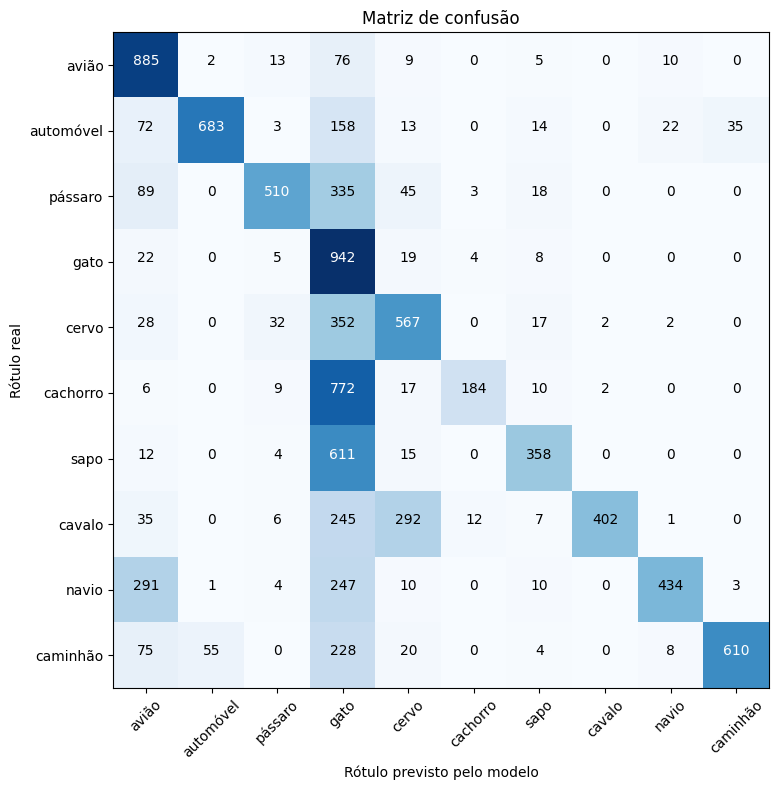

In [6]:
# Previsões no conjunto de teste
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Matriz de confusão
confusion_matrix = confusion_matrix(y_true, y_pred_classes)

def plot_confusion_matrix(cm, classes, normalize=False, title='Matriz de confusão', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Rótulo real')
    plt.xlabel('Rótulo previsto pelo modelo')
    plt.tight_layout()



# Plotando a matriz de confusão
plot_confusion_matrix(confusion_matrix, classes)
plt.show()